# Accountant Age Analysis Using IPUMS USA

This notebook analyzes the age distribution of **Accountants and Auditors** using IPUMS USA microdata.

**Goals:**
- Import and combine raw IPUMS files (`usa_0000x.csv.gz`)
- Clean and format variables
- Create new variables (age groups, career stages)
- Check for duplicates and missing data and decide how to handle them
- Compute summary statistics (means, medians, distribution by year)
- Produce clear visualizations for the final presentation:
  - Trend in average age of accountants over time
  - Age-group distribution for the most recent year


In [16]:
import matplotlib.pyplot as plt

# Bigger, readable fonts for *all* plots
plt.rcParams["font.size"] = 12      # base size
plt.rcParams["axes.titlesize"] = 18 # plot titles
plt.rcParams["axes.labelsize"] = 14 # x/y labels
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12

# Plot settings
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = True



## 1. Load and Combine Raw IPUMS Files

IPUMS provided multiple compressed files (`usa_0000x.csv.gz`).
In this step, we:

- Find all `usa_*.csv.gz` files in `data_raw`
- Read each into pandas
- Stack them into one combined DataFrame `usa_all`

This "join" of multiple raw files is our first dataset combination step.


In [17]:
# Find all IPUMS CSVs
raw_files = sorted(DATA_RAW_DIR.glob("usa_*.csv.gz"))
print("Raw files found:", [f.name for f in raw_files])

usa_dfs = []
for f in raw_files:
    print(f"Loading {f.name} ...")
    tmp = pd.read_csv(f, compression="infer", low_memory=False)
    usa_dfs.append(tmp)

usa_all = pd.concat(usa_dfs, ignore_index=True)
print("Stacked shape:", usa_all.shape)

print("Raw columns:")
list(usa_all.columns)


Raw files found: ['usa_00003.csv.gz', 'usa_00005.csv.gz', 'usa_00006.csv.gz', 'usa_00007.csv.gz']
Loading usa_00003.csv.gz ...
Loading usa_00005.csv.gz ...
Loading usa_00006.csv.gz ...
Loading usa_00007.csv.gz ...
Stacked shape: (134261368, 21)
Raw columns:


['YEAR',
 'SAMPLE',
 'SERIAL',
 'CBSERIAL',
 'HHWT',
 'CLUSTER',
 'STRATA',
 'GQ',
 'PERNUM',
 'PERWT',
 'OCC',
 'EDUC',
 'EDUCD',
 'DEGFIELD',
 'DEGFIELDD',
 'DEGFIELD2',
 'DEGFIELD2D',
 'AGE',
 'IND',
 'INCTOT',
 'SEX']

## 2. Cleaning and Formatting Variables

Next, we:

- Standardize column names to snake_case
- Keep only the variables needed for the analysis:
  - `year` – survey year
  - `age` – respondent age
  - `occ` – occupation code
  - `perwt` – person weight (used for weighted statistics)
  - Additional variables (if present): `sex`, `educ`, `inctot`, `incwage`


In [3]:
# Standardize column names
usa_all.columns = (
    usa_all.columns
        .str.lower()
        .str.strip()
        .str.replace(" ", "_")
        .str.replace("-", "_")
)

print("Standardized columns:")
print(list(usa_all.columns))

# Keep relevant columns (only if they exist in this extract)
keep_cols = [c for c in [
    "year",      # survey year
    "age",       # age in years
    "occ",       # occupation code
    "perwt",     # person weight
    "sex",       # gender (if present)
    "educ",      # education (if present)
    "inctot",    # total income (if present)
    "incwage"    # wage income (if present)
] if c in usa_all.columns]

acct_raw = usa_all[keep_cols].copy()
print("Core dataset shape:", acct_raw.shape)
acct_raw.head()


Standardized columns:
['year', 'sample', 'serial', 'cbserial', 'hhwt', 'cluster', 'strata', 'gq', 'pernum', 'perwt', 'occ', 'educ', 'educd', 'degfield', 'degfieldd', 'degfield2', 'degfield2d', 'age', 'ind', 'inctot', 'sex']
Core dataset shape: (134261368, 7)


,year,age,occ,perwt,sex,educ,inctot
0,2013,NaN,0.0,65.0,NaN,NaN,NaN
1,2013,NaN,4700.0,51.0,NaN,NaN,NaN
2,2013,NaN,7240.0,62.0,NaN,NaN,NaN
3,2013,NaN,0.0,232.0,NaN,NaN,NaN
4,2013,NaN,0.0,97.0,NaN,NaN,NaN


## 3. Create Analysis Dataset: Accountants Only

Here we:

- Convert key columns to numeric
- Filter to **Accountants and Auditors** (occupation code `OCC = 800`)
- Restrict to **working-age** individuals (ages 18–65)
- This becomes our main analysis dataset `acct`.


In [18]:
# Convert key columns to numeric
for col in ["year", "age", "occ", "perwt"]:
    if col in acct_raw.columns:
        acct_raw[col] = pd.to_numeric(acct_raw[col], errors="coerce")

# Filter to accountants & auditors (OCC == 800)
acct = acct_raw[acct_raw["occ"] == 800].copy()
print("Accountant records (any age):", acct.shape)

# Restrict to working-age 18–65
acct = acct[(acct["age"] >= 18) & (acct["age"] <= 65)]
print("Accountants, ages 18–65:", acct.shape)

acct.head()


Accountant records (any age): (708462, 7)
Accountants, ages 18–65: (425708, 7)


,year,age,occ,perwt,sex,educ,inctot
64490270,2013,29.0,800.0,7.0,NaN,NaN,45000.0
64490649,2013,36.0,800.0,22.0,NaN,NaN,73000.0
64490780,2013,63.0,800.0,76.0,NaN,NaN,79270.0
64490980,2013,57.0,800.0,62.0,NaN,NaN,31800.0
64490981,2013,33.0,800.0,18.0,NaN,NaN,51000.0


## 4. Creating New Variables: Age Groups and Career Stages

To better summarize the age distribution, we create:

- **Age groups** in roughly 5-year bands from 18–65
- **Career stage**:
  - 18–29: Early career
  - 30–44: Mid career
  - 45–65: Late career


In [19]:
# Age group bins & labels
age_bins   = [18, 25, 30, 35, 40, 45, 50, 55, 60, 65]
age_labels = ["18–24","25–29","30–34","35–39","40–44",
              "45–49","50–54","55–59","60–65"]

acct["age_group"] = pd.cut(
    acct["age"],
    bins=age_bins,
    labels=age_labels,
    right=False
)

# Simple career stage variable
acct["career_stage"] = pd.cut(
    acct["age"],
    bins=[18, 30, 45, 65],
    labels=["Early career", "Mid career", "Late career"],
    right=False
)

acct[["year", "age", "age_group", "career_stage"]].head()


,year,age,age_group,career_stage
64490270,2013,29.0,25–29,Early career
64490649,2013,36.0,35–39,Mid career
64490780,2013,63.0,60–65,Late career
64490980,2013,57.0,55–59,Late career
64490981,2013,33.0,30–34,Mid career


## 5. Duplicates and Missing Information

Now we check:

- Exact duplicate rows: likely data noise we can safely drop
- Missing values in key variables (`year`, `age`, `occ`, `perwt`)

In the write-up, we will discuss:
- **Why duplicates might occur** (e.g., repeated records, data processing)
- **Why information is missing** and whether we can still use those rows.


In [6]:
# Exact duplicate rows
dup_exact = acct[acct.duplicated(keep=False)]
print("Number of exact duplicate rows:", dup_exact.shape[0])

# Drop exact duplicates
acct = acct.drop_duplicates()
print("Shape after dropping exact duplicates:", acct.shape)

# Missingness summary
missing_summary = acct.isna().sum().sort_values(ascending=False)
missing_summary


Number of exact duplicate rows: 150465
Shape after dropping exact duplicates: (328596, 9)


educ            328596
sex             210222
inctot          118374
age_group         6502
career_stage      6502
year                 0
age                  0
occ                  0
perwt                0
dtype: int64

## 6. Summary Statistics

We compute:

- Overall descriptive statistics for age among accountants
- Year-by-year statistics
- A **weighted average age** by year using `perwt` when available


In [7]:
# Restrict to working-age 20–66
acct = acct[(acct["age"] >= 20) & (acct["age"] <= 66)]
print("Accountants, ages 20–66:", acct.shape)



Accountants, ages 20–66: (328172, 9)


In [8]:
# Summary by year (unweighted)
age_by_year_unweighted = (
    acct.groupby("year")["age"]
        .agg(["count", "mean", "median", "min", "max"])
        .reset_index()
)
age_by_year_unweighted


,year,count,mean,median,min,max
0,2013,32652,43.836733,44.0,20.0,65.0
1,2014,30986,44.064545,45.0,20.0,65.0
2,2015,31453,44.053127,45.0,20.0,65.0
3,2016,31646,44.141629,45.0,20.0,65.0
4,2017,32455,43.907472,44.0,20.0,65.0
5,2018,32430,44.131977,45.0,20.0,65.0
6,2019,28367,44.022843,44.0,20.0,65.0
7,2020,23653,44.068448,44.0,20.0,65.0
8,2021,28112,43.976878,44.0,20.0,65.0
9,2022,28157,43.839543,44.0,20.0,65.0


In [9]:
# Weighted average age by year (if perwt exists)
def weighted_mean(group, val_col, wt_col):
    v = group[val_col]
    w = group[wt_col]
    return (v * w).sum() / w.sum()

if "perwt" in acct.columns:
    # Select only the needed columns to avoid the FutureWarning
    age_by_year_weighted = (
        acct.groupby("year")[["age", "perwt"]]
            .apply(lambda g: weighted_mean(g, val_col="age", wt_col="perwt"))
            .reset_index(name="avg_age_weighted")
    )
else:
    # Fallback: use unweighted mean if perwt missing
    age_by_year_weighted = (
        acct.groupby("year")["age"]
            .mean()
            .reset_index(name="avg_age_weighted")
    )

age_by_year_weighted



,year,avg_age_weighted
0,2013,42.802561
1,2014,42.831996
2,2015,42.970662
3,2016,42.845722
4,2017,42.720041
5,2018,42.946620
6,2019,42.857442
7,2020,42.921136
8,2021,42.800683
9,2022,42.567343


## 7. Visualization: Average Age of Accountants Over Time

This line chart shows how the **weighted average age** of accountants has changed over the years included in the IPUMS extract.

This is a good slide for:
- Showing whether the profession is aging or getting younger
- Connecting to themes like pipeline, retirement, or recruitment.


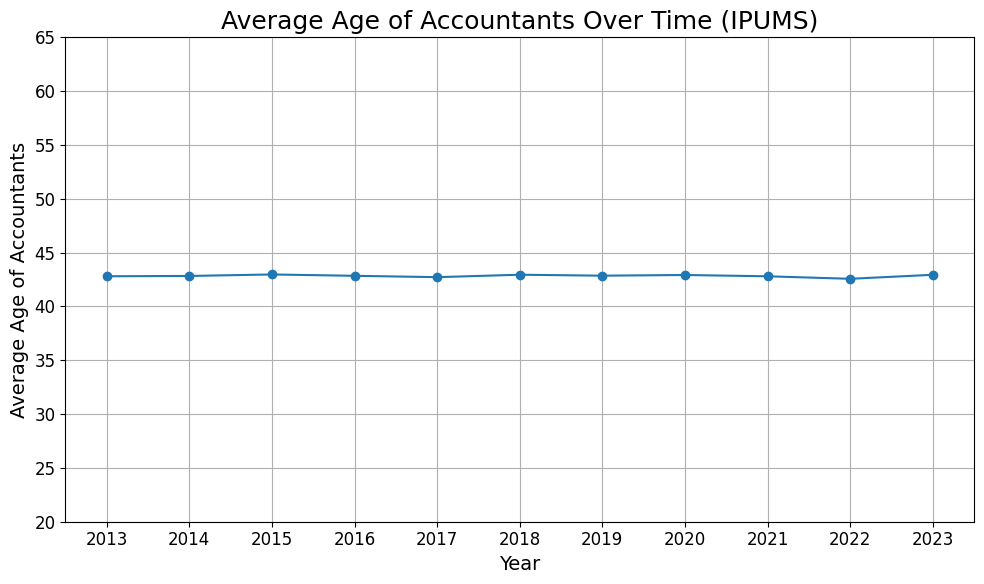

In [20]:
plt.figure()

plt.plot(
    age_by_year_weighted["year"],
    age_by_year_weighted["avg_age_weighted"],
    marker="o"
)

plt.title("Average Age of Accountants Over Time (IPUMS)")
plt.xlabel("Year")
plt.ylabel("Average Age of Accountants")
plt.xticks(age_by_year_weighted["year"])

# Show the age range clearly on the left: 20–65
plt.ylim(20, 65)

plt.tight_layout()
plt.show()


## 8. Visualization: Age Distribution in the Most Recent Year

Next, we look at the **age-group distribution** for the latest year in the IPUMS extract.
This helps answer: *Is the profession dominated by early-career workers, mid-career, or late-career accountants?*


In [12]:
plt.figure()

plt.plot(
    age_by_year_weighted["year"],
    age_by_year_weighted["avg_age_weighted"],
    marker="o",
    label="Weighted Average Age"
)

plt.plot(
    age_by_year_weighted["year"],
    age_by_year_weighted["avg_age"],
    marker="s",
    linestyle="--",
    label="Simple Average Age"
)

plt.title("Average Age of Accountants Over Time")
plt.xlabel("Year")
plt.ylabel("Age")
plt.xticks(age_by_year_weighted["year"])
plt.legend()
plt.tight_layout()
plt.show()


In [14]:
# Identify latest year
latest_year = int(acct["year"].max())
print("Most recent year in extract:", latest_year)

acct_latest = acct[acct["year"] == latest_year].copy()

# Weighted counts by age group (no warnings)
if "perwt" in acct_latest.columns:
    age_group_counts = (
        acct_latest.groupby("age_group", observed=False)["perwt"]
                   .sum()
                   .reindex(age_labels)  # keep your custom order
    )
else:
    age_group_counts = (
        acct_latest["age_group"]
                     .value_counts()
                     .reindex(age_labels)
    )

age_group_counts


Most recent year in extract: 2023


age_group
18–24    183537.0
25–29    357839.0
30–34    395634.0
35–39    376201.0
40–44    360961.0
45–49    325395.0
50–54    337271.0
55–59    326426.0
60–65    325051.0
Name: perwt, dtype: float64

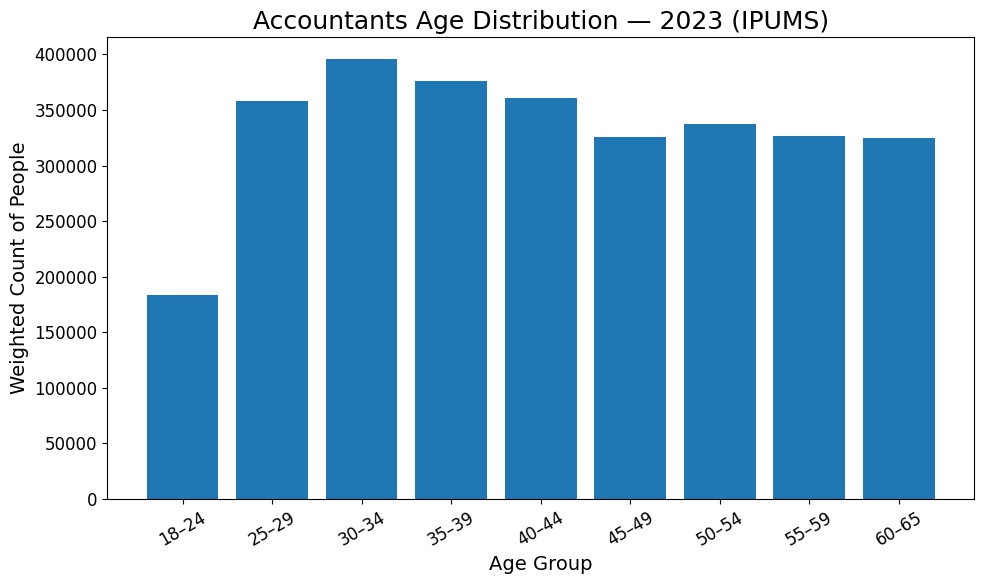

In [21]:
plt.figure()
plt.grid(False)
plt.bar(age_group_counts.index.astype(str), age_group_counts.values)

plt.title(f"Accountants Age Distribution — {latest_year} (IPUMS)")
plt.xlabel("Age Group")
plt.ylabel("Weighted Count of People")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


## 9. Interpretation and Observations (Notes for Presentation)

- The **overall mean age** of accountants is approximately: *(fill in from `age_desc`)*
- The **average age over time** appears to: *(increase / stay flat / decrease)* between the earliest and latest years.
- In the **most recent year (`latest_year`)**:
  - The largest age group is: *(e.g., 30–34 or 45–49)*
  - There is a noticeable share of accountants in the **Late career** category, which may have implications for retirements and pipeline.
- Potential reasons for these patterns:
  - Pipeline of new entrants into the profession
  - Retention and burnout issues
  - Changing education/licensure requirements

These bullet points can be turned directly into speaking notes for the final presentation.
